In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [2]:
data_TPXO = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
lon = np.squeeze(np.array(data_TPXO['lon_z'])[:,0])
lat = np.squeeze(np.array(data_TPXO['lat_z'])[0,:])
am = data_TPXO['ha'].isel({'nc':0}).transpose()
ph = data_TPXO['hp'].isel({'nc':0}).transpose() + 13*180/16

In [3]:
ph_ar = np.array(ph)
ny, nx = ph_ar.shape
for j in range(ny):
    for i in range(nx):
        if ph_ar[j,i]>360:
            ph_ar[j,i] = ph_ar[j,i] - 360
        if ph_ar[j,i]<0:
            ph_ar[j,i] = ph_ar[j,i] + 360

In [4]:
np.array(ph_ar).shape

(1081, 2160)

In [5]:
np.nanmin(ph_ar)

2.5622985390327813e-05

In [6]:
np.nanmax(ph_ar)

359.9998803170671

In [7]:
grid_TPXO = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
mz = grid_TPXO.mz.transpose()

In [8]:
am_arr = np.array(am)
mz_arr = np.array(mz)
am_arr[mz_arr==0] = np.nan
am_nan = xr.DataArray(am_arr, dims=['lat','lon'], coords={'lat': lat, 
                                                          'lon': lon})
# land = xr.where(np.isnan(am_nan.rename('land')), 1, np.nan)

In [9]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
grid_JSL = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_025_SAL_JSL_masked/output003/ocean_static.nc')
geolon = np.array(grid_JSL['geolon'])
geolat = np.array(grid_JSL['geolat'])
yh, xh = grid_JSL.yh, grid_JSL.xh
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), geolon),
                              'lat': (('yh', 'xh'), geolat)})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

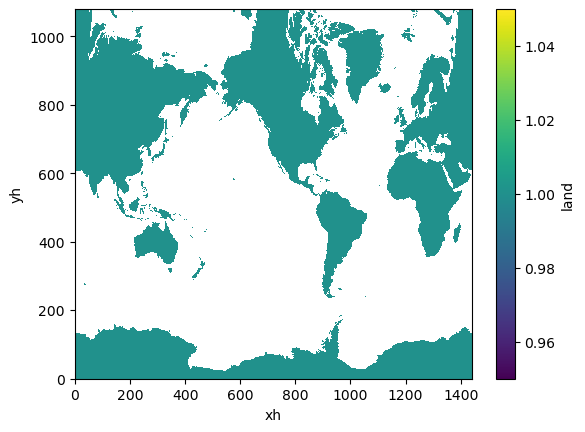

In [10]:
land.plot()

Start plotting...
0
Plotting topog...
Plotting amp...
Plotting phase...
1
Plotting topog...
Plotting amp...
Plotting phase...
Saving...


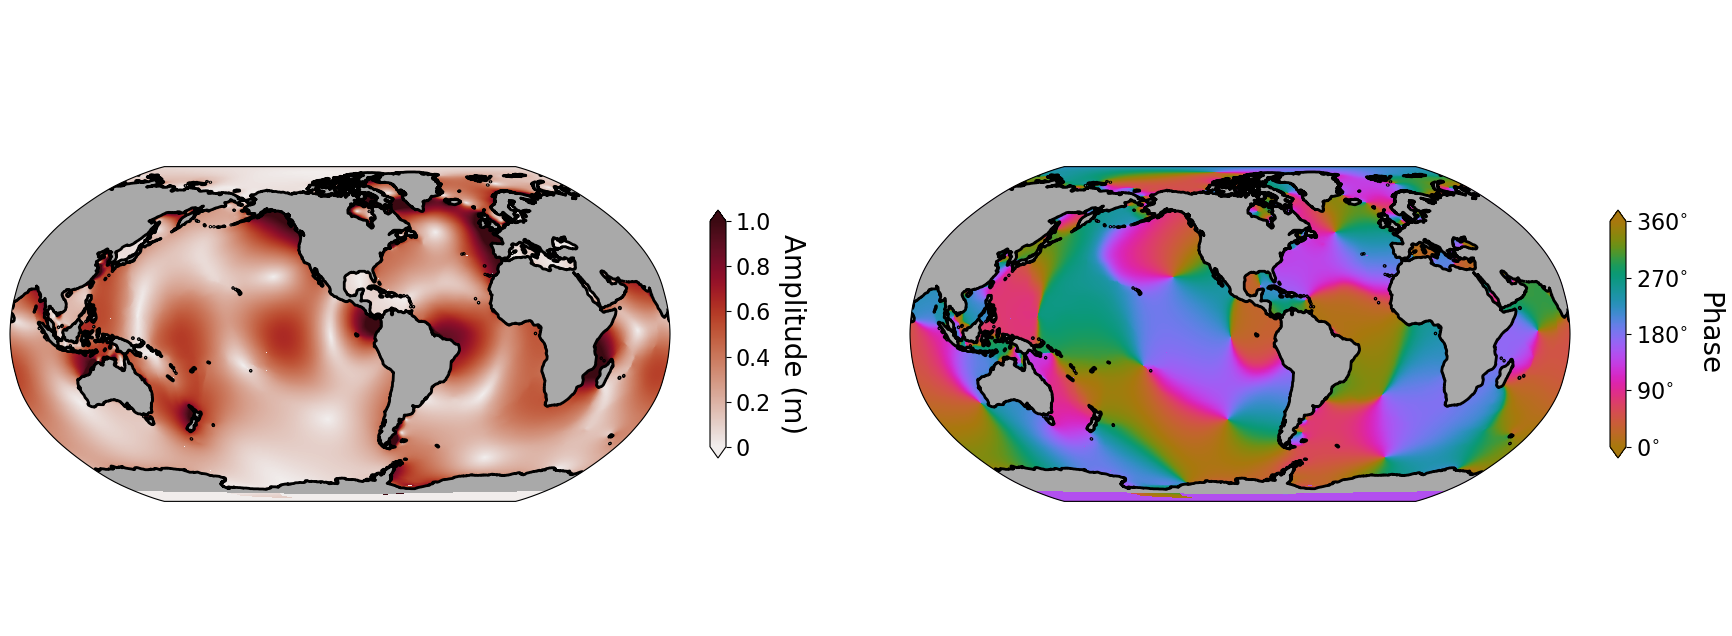

In [11]:
varlist = ['am','ph_ar']
title   = ['amplitude (m)', 'phase (deg)']

fig = plt.figure(figsize=(20, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    print('Plotting topog...')
    if I<2:
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
        # Add model land mask
        land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
        # Add model coastline
        land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=2)

    print('Plotting amp...')
    if I==0:
        p1 = ax.pcolormesh(lon, lat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.amp, vmin=0, vmax=1) #norm=LogNorm(vmin=1e-2, vmax=1e-0)
        tick_locs = np.array([0,0.2,0.4,0.6,0.8,1.0])
        tick_labels = np.array(["0","0.2","0.4","0.6","0.8","1.0"])
        ax_cb = plt.axes([0.45, 0.32, 0.008, 0.31])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Amplitude (m)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.1,0.1,0.33,0.75])

    print('Plotting phase...')
    if I==1:
        p1 = ax.pcolormesh(lon, lat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.phase, vmin=0, vmax=360)
        tick_locs = np.array([0,90,180,270,360])
        tick_labels = np.array(["0$^{\circ}$","90$^{\circ}$","180$^{\circ}$","270$^{\circ}$","360$^{\circ}$"])
        ax_cb = plt.axes([0.9, 0.32, 0.008, 0.31])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Phase',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.55,0.1,0.33,0.75])

print('Saving...')
plt.savefig('/g/data/nm03/lxy581/evaluate/amp_phase/TPXO_M2.png', dpi=300, bbox_inches='tight')